# Calculate Z-scores for players

This takes the list of players that we're trying to calculate scores for, and creates z-scores for players with an arbitrarily chosen minimum innings (for pitchers) or plate appearances (for hitters).

Notes for this year's sheet:

- Z-score avg/stdev calculated using minimum IP or PA stats for batting and pitching.
- Reliever value was artificially decremented as usual since they're normally over-inflated value-wise. Multiplied by (project innings) / (90th pctile of projected innings), capped at 1.0.

In [1]:
import pandas as pd
import numpy as np
import os
import sqlalchemy
import psycopg2
import seaborn as sb
import requests
from datetime import datetime

# arbitrarily high max view columns
pd.options.display.max_columns = 150
pd.options.display.max_rows = 200

## Postgres Connection Information

These are used to get and return a connection to the postgres DB so that we can query for player stats and write them back to the table.

In [4]:
# connection information for the database
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_IP = "192.168.0.103"
POSTGRES_PORT = 5432
POSTGRES_DB = "postgres"


def get_sqlalchemy_engine():
    """
    Create and return a SQLAlchemy engine for inserting into postgres.
    """
    # ## Write Information Back to Database
    #
    return sqlalchemy.create_engine(
        "postgresql://{user}:{password}@{host}:{port}/{db}".format(
            user=POSTGRES_USER,
            password=POSTGRES_PASSWORD,
            host=POSTGRES_IP,
            port=POSTGRES_PORT,
            db=POSTGRES_DB,
        )
    )

In [5]:
# create a connection and read in pitchers data
engine = get_sqlalchemy_engine()
conn = engine.connect()

## Get Player Data and Create Calculated Columns

For each of the players, we calculate a z-score based on how they compare to the rest of the league. There are several columns that we want to do this for.

- For each z-score, there is an arbitrary minimum set to inflate the league average away from non-full-time players.
- After each is totaled, the z-scores are totaled and then z-scored again to make a single number. This is done so that we can compare pitchers and batters into the same chart.

In [6]:
# read in information from postgres
dfp = pd.read_sql(
    "select * from fantasy.pitchers_projections_depth_charts where ip > 0.0", conn
)
dfb = pd.read_sql("select * from fantasy.batters_projections_depth_charts", conn)
dfe = pd.read_sql(
    sqlalchemy.text(
        """
        select
            fullname as "name",
            eligibility as "elig",
            position as "pos",
            case when position like '%P%' then 'p' else 'b' end as catg,
            injurystatus as "injured",
            averagedraftposition as "espnAdp",
            draftrank as "espnDraftRank",
            percentchange as "espnAdpChng",
            percentowned as "pctOwn",
            percentstarted as "pctStart",
            auctionValue as "espnAuctionValue",
            proteamid as "proTeamId", -- just for the join
            espn_id as "espnId"
        from fantasy.players
    """
    ),
    conn,
)
dfpl = pd.read_sql(
    sqlalchemy.text(
        """
        select
            name,
            rank as "pListRank",
            tier as "pListTier"
        from fantasy.pitchers_pitcherlist_100
    """
    ),
    conn,
)

In [7]:
# create any calculated columns necessary
# the calculation for runs created is the simplest of the ones i investigated last year:
# https://zmsy.co/blog/reverse-engineering-espn/#calculating-using-existing-rc-formulas
# RC = ((Hits + Walks) x Total Bases) ÷ (At Bats + Walks)
dfb["tb"] = ((dfb["h"] - dfb["2b"] - dfb["3b"] - dfb["hr"]) + (dfb["2b"] * 2) + (dfb["3b"] * 3) + (dfb["hr"] * 4))
dfb["rc"] = (((dfb["h"] + dfb["bb"]) * dfb["tb"]) / dfb["pa"]).round(2)
dfb["catg"] = "b"

# quality starts metric from here:
# https://yourfantasyjoe.blogspot.com/2010/02/projecting-quality-starts.html
# xQS = GS * (.4650115 - (ERA * .0872381) + ((IP/GS) * .0746775))
dfp["qs"] = (
    dfp["gs"]
    * (0.4650115 - (dfp["era"] * 0.0872381) + ((dfp["ip"] / dfp["gs"]) * 0.0746775))
).round(2)
dfp.fillna(value={"qs": 0.0}, inplace=True)
dfp["catg"] = "p"

print()  # prevent df from printing

### Replace Player Names with Canonical ESPN Names

Multiple inputs have different spellings or variations on player names. The ESPN ones are considered gospel for this analysis.

In [8]:
# source name -> espn name
name_replacements = {
    "Adolis García": "Adolis Garcia",
    "Alex Colomé": "Alex Colome",
    "Alexis Díaz": "Alexis Diaz",
    "Andrés Giménez": "Andres Gimenez",
    "Andrés Muñoz": "Andres Munoz",
    "Andy Ibáñez": "Andy Ibanez",
    "Avisaíl García": "Avisail Garcia",
    "Carlos Hernández": "Carlos Hernandez",
    "Carlos Rodón": "Carlos Rodon",
    "César Hernández": "Cesar Hernandez",
    "Christian Vázquez": "Christian Vazquez",
    "Domingo Germán": "Domingo German",
    "Eduardo Rodríguez": "Eduardo Rodriguez",
    "Edwin O Díaz": "Edwin Diaz",
    "Elias Díaz": "Elias Diaz",
    "Eloy Jiménez": "Eloy Jimenez",
    "Enrique Hernández": "Enrique Hernandez",
    "Eugenio Suárez": "Eugenio Suarez",
    "Félix Bautista": "Felix Bautista",
    "Francisco Álvarez": "Francisco Alvarez",
    "Gary Sánchez": "Gary Sanchez",
    "Génesis Cabrera": "Genesis Cabrera",
    "Germán Márquez": "German Marquez",
    "Harold Ramírez": "Harold Ramirez",
    "Héctor Neris": "Hector Neris",
    "Jarlín García": "Jarlin Garcia",
    "Javier Báez": "Javier Baez",
    "Jeremy Peña": "Jeremy Pena",
    "Jesús Aguilar": "Jesus Aguilar",
    "Jesús Luzardo": "Jesus Luzardo",
    "Jesús Sánchez": "Jesus Sanchez",
    "Jonathan Loáisiga": "Jonathan Loaisiga",
    "Jorge López": "Jorge Lopez",
    "José Abreu": "Jose Abreu",
    "José Alvarado": "Jose Alvarado",
    "José Berríos": "Jose Berrios",
    "José Cisnero": "Jose Cisnero",
    "José Iglesias": "Jose Iglesias",
    "José Leclerc": "Jose Leclerc",
    "José Quintana": "Jose Quintana",
    "José Ramírez": "Jose Ramirez",
    "José Ruiz": "Jose Ruiz",
    "José Suarez": "Jose Suarez",
    "José Urquidy": "Jose Urquidy",
    "Julio Rodríguez": "Julio Rodriguez",
    "Julio Urías": "Julio Urias",
    "Luis Patiño": "Luis Patino",
    "Luis Urías": "Luis Urias",
    "Luis Robert Jr.": "Luis Robert",
    "Manny Piña": "Manny Pina",
    "Martín Pérez": "Martin Perez",
    "Michael Conforto": "Michael Conforto",
    "Michael Soroka": "Mike Soroka",
    "Miguel Sanó": "Miguel Sano",
    "Noé Ramirez": "Noe Ramirez",
    "Odúbel Herrera": "Odubel Herrera",
    "Omar Narváez": "Omar Narvaez",
    "Pablo López": "Pablo Lopez",
    "Ramón Laureano": "Ramon Laureano",
    "Ramón Urías": "Ramon Urias",
    "Ranger Suárez": "Ranger Suarez",
    "Reynaldo López": "Reynaldo Lopez",
    "Robinson Canó": "Robinson Cano",
    "Ronald Acuña Jr.": "Ronald Acuna Jr.",
    "Seranthony Domínguez": "Seranthony Dominguez",
    "Sixto Sánchez": "Sixto Sanchez",
    "Teoscar Hernández": "Teoscar Hernandez",
    "Vidal Bruján": "Vidal Brujan",
    "Yandy Díaz": "Yandy Diaz",
    "Yimi García": "Yimi Garcia",
    "Yoán Moncada": "Yoan Moncada",
    "Yusmeiro Petit": "Yusmeiro Petit",
}


def replace_names(name):
    """
    If a name is in the name_replacements list, get it. Otherwise return the rows name.
    """
    return name_replacements.get(name, name)


# replace all names in all dataframes
for df in [dfb, dfp, dfe, dfpl]:
    df["name"] = df["name"].apply(lambda x: replace_names(x))

## Calculate Z-Scores

The "thresholds" you see below are used to calculate the z-scores of any particular player based on players who are likely full time players. This is to avoid the long-tail of replacement-level players skewing the average lower.

`min_pa`-type vectors are created below to use as filters for the individual dataframes for batter/pitcher.

In [9]:
# thresholds for batters and pitchers
MINIMUM_INNINGS_PITCHED = 100
MINIMUM_INNINGS_PITCHED_ACTUALS = 20.0
MINIMUM_PLATE_APPEARANCES = 180
MINIMUM_PLATE_APPEARANCES_ACTUALS = 120

# filter columns
min_pa = dfb["pa"] > MINIMUM_PLATE_APPEARANCES
min_ip = dfp["ip"] > MINIMUM_INNINGS_PITCHED

# dict of columns that we want to calculate z-scores for
# +1 means more is better, -1 means negative is better
dfb_score_cols = {
    "pa": {"dir": 1, "weight": 1.25},
    "k_pct": {"dir": -1, "weight": 0.9},
    "hr": {"dir": 1, "weight": 1.015},
    "rc": {"dir": 1, "weight": 1.35},
    "woba": {"dir": 1, "weight": 1.325},
    "slg": {"dir": 1, "weight": 1.0},
    "adp": {"dir": -1, "weight": 0.3},
}
dfp_score_cols = {
    "ip": {"dir": 1, "weight": 1.2625},
    "era": {"dir": -1, "weight": 1.0},
    "hr": {"dir": -1, "weight": 0.95},
    "so": {"dir": 1, "weight": 1.05},
    "whip": {"dir": -1, "weight": 1.3},
    "k_per_9": {"dir": 1, "weight": 1.3},
    "qs": {"dir": 1, "weight": 1.05},
    "gs": {"dir": 1, "weight": 0.25},
}

dfb_weight = 1.0
dfp_weight = 0.85

# get all of the score columns for maximum z-scoring
dfb_score_col_names = [x + "_score" for x in dfb_score_cols.keys()]
dfp_score_col_names = [x + "_score" for x in dfp_score_cols.keys()]

### Calculate Scores and Totals

Totals are used for quickly ranking players across the different P / B groups.

In [10]:
# only mean and stdev are filtered by minimums, so that way the player's actual
# projections are still counted normally.

# batter scores
for col in dfb_score_cols.keys():
    col_score = col + "_score"
    dfb[col_score] = (
        (dfb[col] - dfb[col][min_pa].mean())
        / dfb[col][min_pa].std(ddof=0)
        * dfb_score_cols[col]["dir"]
        * dfb_score_cols[col]["weight"]
    ).round(3)

# pitcher scores
for col in dfp_score_cols.keys():
    col_score = col + "_score"
    dfp[col_score] = (
        (dfp[col] - dfp[col][min_ip].mean())
        / dfp[col][min_ip].std(ddof=0)
        * dfp_score_cols[col]["dir"]
        * dfp_score_cols[col]["weight"]
    ).round(3)

In [11]:
# sum all of the values into 'total_score'
dfb["total_score"] = dfb[dfb_score_col_names].sum(axis=1)
dfb["total_z_score"] = (dfb["total_score"] - dfb["total_score"][min_pa].mean()) / dfb[
    "total_score"
][min_pa].std(ddof=0)
dfb["total_z_score_rank"] = dfb["total_z_score"].rank(ascending=False)
dfb["total_z_score"] = dfb.total_z_score.round(3) * dfb_weight

dfp["total_score"] = dfp[dfp_score_col_names].sum(axis=1)
dfp["total_z_score"] = (dfp["total_score"] - dfp["total_score"][min_ip].mean()) / dfp[
    "total_score"
][min_ip].std(ddof=0)
dfp["total_z_score_rank"] = dfp["total_z_score"].rank(ascending=False)
dfp["total_z_score"] = dfp.total_z_score.round(3) * dfp_weight

# sort by score descending
dfb.sort_values(by="total_z_score_rank", inplace=True)
dfp.sort_values(by="total_z_score_rank", inplace=True)

### Inflate League Mean

For the majority of the z-scores that we're taking, the actual values of them are affected by the long-tail of players who don't get much playing time. To offset this, the mean is artifically placed at halfway through our number of drafted players to account for the fact that will be replacement level for our league.

In [12]:
# decrement scores by the mean of all drafted positions
NUM_TEAMS = 12
NUM_BATTERS = 15
NUM_PITCHERS = 10

MIDDLE_BATTER_INDEX = int((NUM_TEAMS * NUM_BATTERS) / 2)
MIDDLE_PITCHER_INDEX = int((NUM_TEAMS * NUM_PITCHERS) / 2)

middle_batter_score = dfb[dfb["total_z_score_rank"] == MIDDLE_BATTER_INDEX][
    "total_z_score"
]
dfb["total_z_score"] = dfb["total_z_score"] - float(middle_batter_score)
dfb.reset_index(drop=True)

middle_pitcher_score = dfp[dfp["total_z_score_rank"] == MIDDLE_PITCHER_INDEX][
    "total_z_score"
]
dfp["total_z_score"] = dfp["total_z_score"] - float(middle_pitcher_score)
dfp.reset_index(drop=True)

print()  # prevent df from printing

## Write to the Database

Prior to writing the excel files, write back to the database for safekeeping.

In [13]:
dfb.to_sql("batters_scores", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.batters_scores to public")

dfp.to_sql("pitchers_scores", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.pitchers_scores to public")

## Create Draft Sheet

This sheet includes a number of important pieces of information for drafting specifically, so that players can look up by eligibility as well as important stats.

- Name
- Eligibility
- Positions
- Combined scores

In [14]:
# name and espnteamid are the join columns
cols = ["name", "espnteamid", "total_z_score"]
df = (
    pd.concat([dfb[cols], dfp[cols]])
    .groupby(by=["name", "espnteamid"])
    .sum() # sum them to deal with shohei breaking all assumptions
    .reset_index()
    .sort_values(by="total_z_score", ascending=False)
)
df.rename(columns={"total_z_score": "score"}, inplace=True)

# merge in ESPN player data
dfy = pd.merge(dfe, df, left_on=["name", "proTeamId"], right_on=["name", "espnteamid"], how="left")
dfd = pd.merge(dfy, dfpl, on="name", how="left")

# fill in missing type values, need to adjust names later
dfd["elig"] = dfd["elig"].astype("str").replace(to_replace="nan", value="")
dfd["pos"] = dfd["pos"].astype("str").replace(to_replace="nan", value="")

# nix any missing rows at this point
# dfd.dropna(inplace=True)

## Create Positional Scarcity Metrics

Players are grouped into the _most scarce_ position that they're eligible for. Scarcity is defined as number of players above replacement value. This creates a map of all positions and the number of players above replacement, and then uses that to group players to which they should be in.

In [15]:
# create a map of positional scarcity
eligibility = {}
for index, player in dfd.iterrows():
    # add all positions to the dict if not yet
    for pos in player["elig"].split("|"):
        if pos not in eligibility:
            eligibility[pos] = 0

        if player["score"] >= 0.0:
            eligibility[pos] += 1


def get_scarcest_eligibility(x):
    """
    Loops through a player's eligibility and puts them in the category that has the least
    number of players that are above replacement level. Arbitrarily set max value unreachably
    high to start so that any eligibility validates.
    """
    best = ""
    best_num = 1000000000
    for pos in x.split("|"):
        pos_num = eligibility[pos]
        if pos_num < best_num:
            best = pos
            best_num = pos_num
    return best


# get the shallowest position that any player is eligible for, as well
# as their primary position (first in the list, generally)
dfd["shallowestPos"] = dfd["elig"].apply(lambda x: get_scarcest_eligibility(x))
dfd["shallowestPosRank"] = dfd.groupby("shallowestPos")["score"].rank(
    "dense", ascending=False
)
dfd["primaryPos"] = dfd["pos"].apply(lambda x: x.split("|")[0])
dfd["primaryPosRank"] = dfd.groupby("primaryPos")["score"].rank(
    "dense", ascending=False
)
dfd["catgRank"] = dfd.groupby("catg")["score"].rank("dense", ascending=False)
dfd["rank"] = dfd["score"].rank(ascending=False, method="first", na_option="bottom")

## Style Output

In order to make the outputs more usable, apply a number of color stylings and ranking scale sliders to the actual xlsx file.

In [16]:
dfd = dfd[
    [
        "rank",
        "name",
        "elig",
        "pos",
        "injured",
        "score",
        "espnAdp",
        "espnAdpChng",
        "espnAuctionValue",
        "espnId",
        "pctOwn",
        "pctStart",
        "catg",
        "pListRank",
        "pListTier",
        "primaryPos"
    ]
]

dfd = dfd.rename(
    columns={
        "espnAdp": "adp",
        "espnAuctionValue": "auctionValue",
        "espnAdpChng": "adp7DayChg",
    }
)

## Write Excel files for distribution

In [17]:
today = datetime.now().strftime("%Y_%m_%d")
with pd.ExcelWriter(f"fantasy_draft_sheet_{today}.xlsx") as writer:
    dfb.to_excel(writer, sheet_name="batters")
    dfp.to_excel(writer, sheet_name="pitchers")
    dfd.to_excel(writer, sheet_name="draft_sheet")

## Draft Sheet Preview

This is a quick look at how the players are going to appear in the final draft sheet. Useful for comparing overall pitcher v batter weights (i.e. verify that nobody should be ranked higher than trout).

In [18]:
dfd.sort_values(by="score", ascending=False).head(150)

,rank,name,elig,pos,injured,score,adp,adp7DayChg,auctionValue,espnId,pctOwn,pctStart,catg,pListRank,pListTier,primaryPos
8,1.0,Shohei Ohtani,UTIL|P|SP,DH|SP,ACTIVE,2.61355,1.87,0.01,53.0,39832,99.81,99.10,p,9.0,T2,DH
1,2.0,Aaron Judge,OF|UTIL,OF|DH,ACTIVE,2.19300,5.28,0.01,35.0,33192,99.84,99.67,b,NaN,NaN,OF
33,3.0,Jacob deGrom,P|SP,SP,ACTIVE,2.04850,26.03,-0.01,31.0,32796,99.55,97.20,p,11.0,T3,SP
17,4.0,Yordan Alvarez,OF|UTIL,OF|DH,ACTIVE,2.02200,17.37,0.03,30.0,36018,99.75,95.04,b,NaN,NaN,OF
2,5.0,Juan Soto,OF|UTIL,OF,DAY_TO_DAY,1.89600,5.88,0.01,52.0,36969,99.83,98.70,b,NaN,NaN,OF
13,6.0,Mike Trout,OF|UTIL,OF,ACTIVE,1.89300,19.24,0.03,26.0,30836,99.80,99.44,b,NaN,NaN,OF
7,7.0,Corbin Burnes,P|SP,SP,ACTIVE,1.82155,10.11,0.02,40.0,39878,99.81,99.39,p,2.0,T1,SP
4,8.0,Vladimir Guerrero Jr.,1B|1B/3B|UTIL,1B|DH,ACTIVE,1.80700,8.60,0.02,40.0,35002,99.82,99.10,b,NaN,NaN,1B
0,9.0,Gerrit Cole,P|SP,SP,ACTIVE,1.75100,8.01,0.02,45.0,32081,99.84,99.53,p,1.0,T1,SP
15,10.0,Kyle Tucker,OF|UTIL,OF,ACTIVE,1.57400,15.63,0.00,34.0,34967,99.78,98.66,b,NaN,NaN,OF


In [19]:
# check for any players where the stats are missing (likely due to bad join on name/team)
dfd[dfd['score'].isna()].head(50)

,rank,name,elig,pos,injured,score,adp,adp7DayChg,auctionValue,espnId,pctOwn,pctStart,catg,pListRank,pListTier,primaryPos
164,1283.0,Rhys Hoskins,1B|1B/3B|UTIL,1B,OUT,NaN,165.73,-23.64,0.0,35291,67.13,47.45,b,NaN,NaN,1B
183,1284.0,Edwin Diaz,P|RP,RP,OUT,NaN,251.93,-30.58,0.0,35394,52.22,40.30,p,NaN,NaN,RP
213,1285.0,Brendan Rodgers,2B|2B/SS|UTIL,2B,SIXTY_DAY_DL,NaN,260.00,-13.39,0.0,35073,27.77,7.17,b,NaN,NaN,2B
298,1286.0,Luis Garcia,2B|SS|2B/SS|UTIL,2B|SS,ACTIVE,NaN,259.31,2.80,0.0,40459,7.37,3.31,b,53.0,T9,2B
355,1287.0,Walker Buehler,P|SP,SP,SIXTY_DAY_DL,NaN,259.65,0.90,0.0,39251,3.72,0.38,p,NaN,NaN,SP
366,1288.0,Gavin Lux,2B|2B/SS|OF|UTIL,2B|OF,OUT,NaN,259.91,-1.20,0.0,40423,3.31,1.21,b,NaN,NaN,2B
387,1289.0,Carlos Estevez,P|RP,RP,ACTIVE,NaN,260.20,1.30,0.0,34861,2.43,1.82,p,NaN,NaN,RP
400,1290.0,Gary Sanchez,C|UTIL,C|DH,ACTIVE,NaN,259.27,0.39,0.0,31095,2.22,1.24,b,NaN,NaN,C
407,1291.0,Jasson Dominguez,OF|UTIL,OF,ACTIVE,NaN,259.85,0.49,0.0,42401,2.09,0.28,b,NaN,NaN,OF
444,1292.0,Joe Jimenez,P|RP,RP,ACTIVE,NaN,260.20,0.74,0.0,33760,1.37,1.02,p,NaN,NaN,RP


# Visualizations

Here are a number of helpful visualizations to sort out the information from the draft sheet.

### ESPN Average Draft Pos vs. this Draft Sheet Ranking

Here's how players stack up against how they're being drafted on ESPN right now

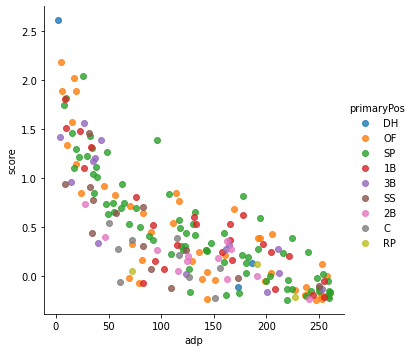

In [20]:
sb.lmplot(
    x="adp",
    y="score",
    hue="primaryPos",
    fit_reg=False,
    data=dfd.sort_values(by="score", ascending=False).head(200),
)

### Scores by Position

Looks at the different positions and how many players there are above replacement level at each.

/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='score', ylabel='primaryPos'>

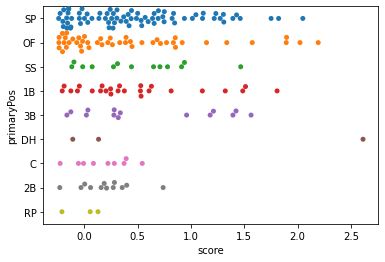

In [21]:
sb.swarmplot(data=dfd[dfd["rank"] <= 200], x="score", y="primaryPos", orient="h")

### Pitcher Score vs PitcherList Tier

PitcherList rankings are some of the most predictive on the internet, 

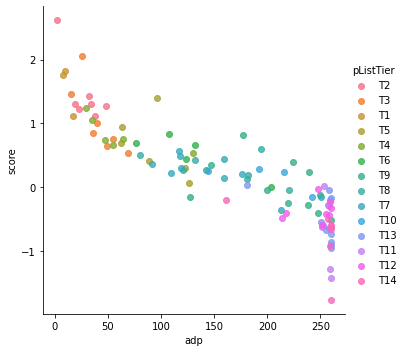

In [22]:
sb.lmplot(
    x="adp",
    y="score",
    hue="pListTier",
    fit_reg=False,
    data=dfd[dfd["pListTier"].notnull()].sort_values(by="score", ascending=False),
)